# Analyze Text of England and Wales Judgements


In [1]:
import os
import json
import string
from datasets import Dataset, DatasetDict, load_dataset, load_from_disk
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
path_ = '/home/stirunag/work/github/ML4-legal-documents/judgements_xml/'
jsonl_file = path_+'england_wales_data_refined_7.jsonl'
dataset_path = path_+'en_judgements_dataset'

In [5]:
data = []
with open(jsonl_file, 'r') as file:
    for line in file:
        data.append(json.loads(line))

dataset = Dataset.from_json(jsonl_file)
dataset_dict = DatasetDict({"train": dataset})

# Save the dataset to disk
dataset.save_to_disk(dataset_path)


Saving the dataset (0/1 shards):   0%|          | 0/6154 [00:00<?, ? examples/s]

In [6]:
# Load the dataset from disk
ds = load_from_disk(dataset_path)

In [7]:
# | eval: false
def tagger(item):
    text = item["content"]
    dummy_tokens = text.split()

    item["chars"] = len(text)
    item["num_dummy_tokens"] = len(dummy_tokens)
    item["num_non_ws_tokens"] = sum(
        1 for tok in dummy_tokens if any(char not in string.punctuation for char in tok.strip())
    )

    return item


ds = ds.map(tagger, num_proc=8)
ds.cleanup_cache_files()

Map (num_proc=8):   0%|          | 0/6154 [00:00<?, ? examples/s]

0

In [8]:
# | eval: false
stats = (
    ds.select_columns(["_id", "type", "appeal_type", "appeal_outcome", "chars", "num_dummy_tokens", "num_non_ws_tokens"])
    .to_pandas()
    .convert_dtypes(dtype_backend="pyarrow")
)
stats["type"] = stats["type"].astype("category")
stats.head()

,_id,type,appeal_type,appeal_outcome,chars,num_dummy_tokens,num_non_ws_tokens
0,ab0224364e4cf6562c82f8861d5268d4fa22b2ec45e0f7...,crown_court,<NA>,<NA>,12444,2229,2155
1,d4630d93258ea51ecff4bc4015443b4eecf8d9b2e5b7c5...,supreme_court,conviction,<NA>,20977,3681,3586
2,37183a714b626cfe98081ac0250c804f992f340281f6d2...,crown_court,<NA>,<NA>,40570,7199,7097
3,b41933b19505ab8767ce30faf8db9524f737ec5ac2c17e...,crown_court,<NA>,<NA>,19459,3515,3432
4,418382a2a6c0c32d3d2bd4cb7b39e1ba259dc6bf56a78e...,crown_court,<NA>,allowed,10352,1879,1793


[Text(0.5, 1.0, '#tokens distribution')]

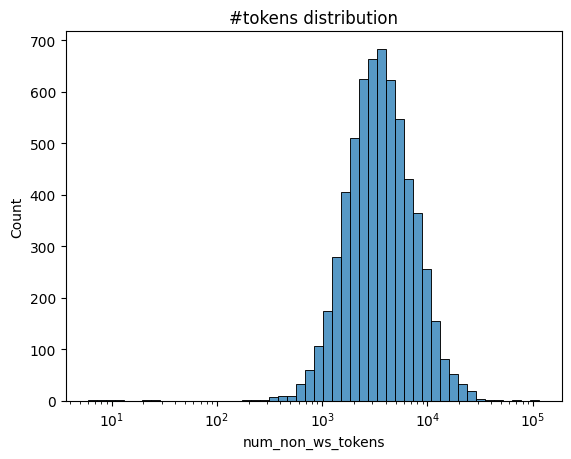

In [9]:
# | eval: false
ax = sns.histplot(
    x=stats["num_non_ws_tokens"],
    log_scale=True,
    bins=50,
)
ax.set(title="#tokens distribution")

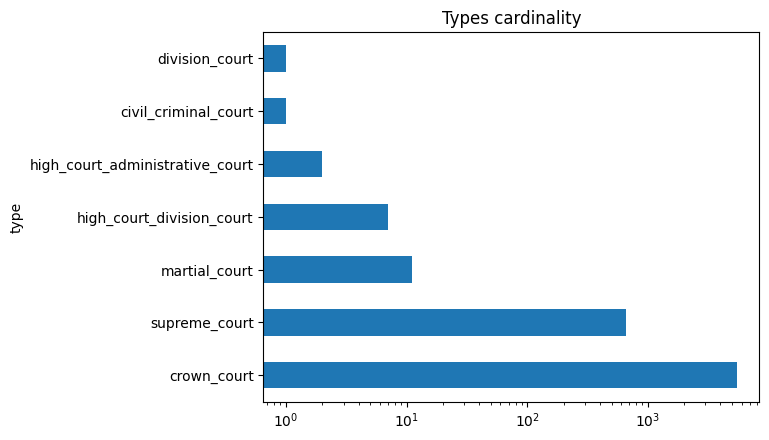

In [23]:
# | eval: false
court_type_card_order = stats["type"].value_counts().index.tolist()
court_type_data = stats["type"].value_counts().plot.barh(logx=True, title="Types cardinality")

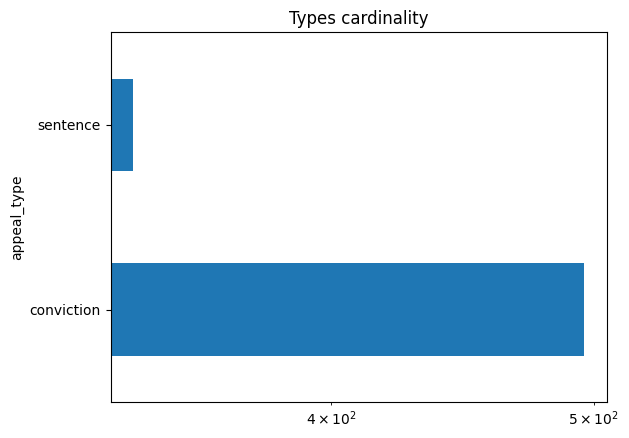

In [24]:
# | eval: false
appeal_type_card_order = stats["appeal_type"].value_counts().index.tolist()
appeal_type_data = stats["appeal_type"].value_counts().plot.barh(logx=True, title="Types cardinality")

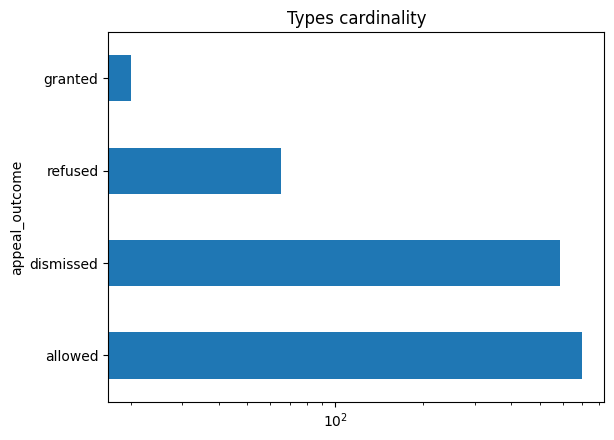

In [25]:
# | eval: false
appeal_outcome_card_order = stats["appeal_outcome"].value_counts().index.tolist()
appeal_outcome_data = stats["appeal_outcome"].value_counts().plot.barh(logx=True, title="Types cardinality")

<Axes: title={'center': 'Per type text length ditribution'}, xlabel='num_non_ws_tokens', ylabel='type'>

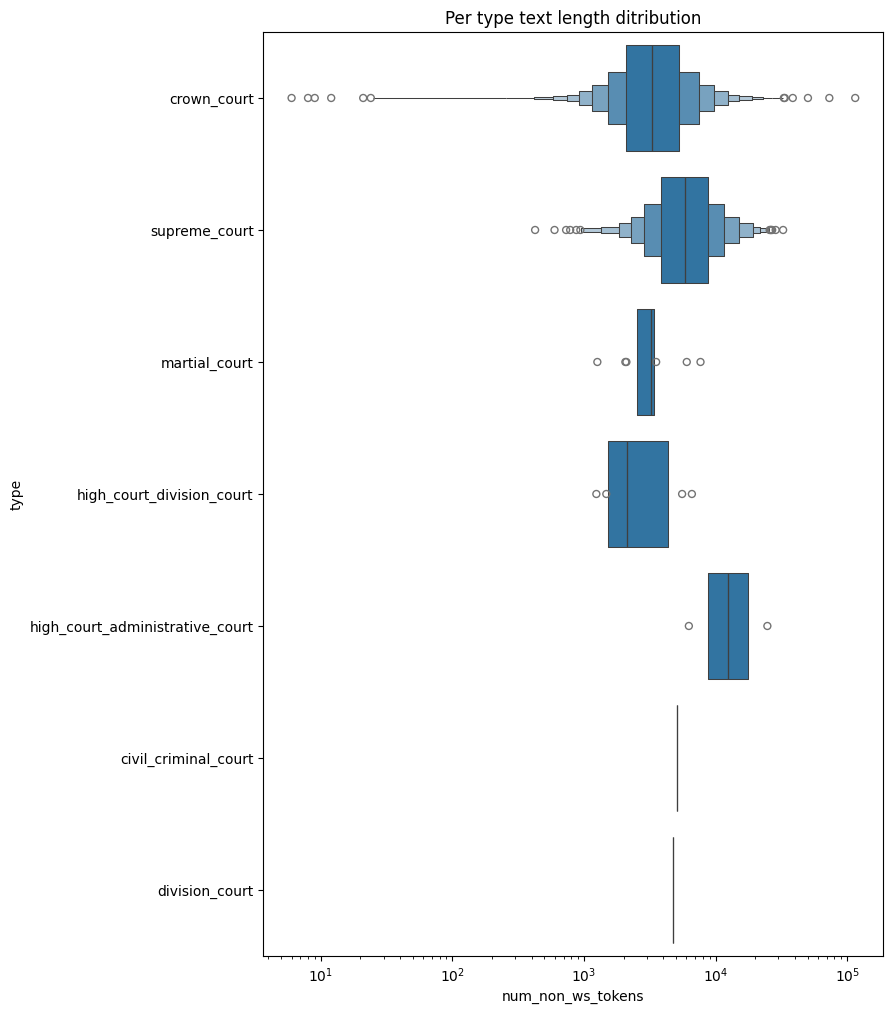

In [26]:
# | eval: false
# sns.displot(data=stats, x="num_non_ws_tokens", col="type", col_wrap=3, log_scale=(True, False), facet_kws=dict(sharey=False, sharex=False), kind="hist", bins=25)

_, ax = plt.subplots(figsize=(8, 12))
ax.set(title="Per type text length ditribution")
sns.boxenplot(data=stats, y="type", x="num_non_ws_tokens", order=court_type_card_order, log_scale=True)

<Axes: title={'center': 'Per type text length ditribution'}, xlabel='num_non_ws_tokens', ylabel='appeal_type'>

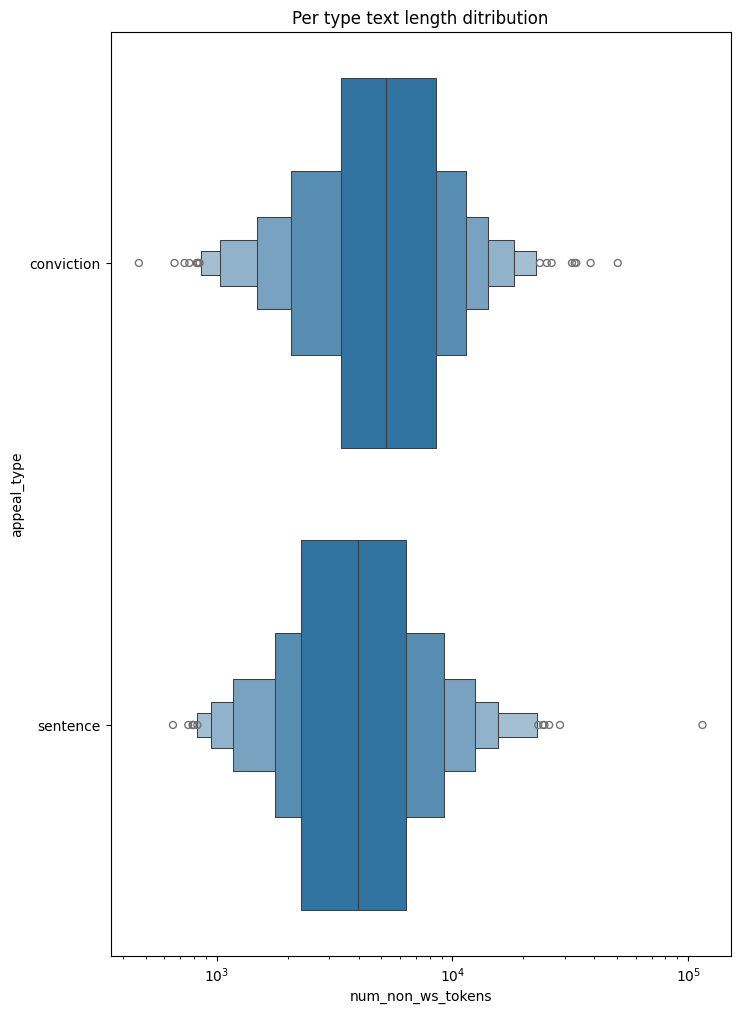

In [29]:
# | eval: false
# sns.displot(data=stats, x="num_non_ws_tokens", col="type", col_wrap=3, log_scale=(True, False), facet_kws=dict(sharey=False, sharex=False), kind="hist", bins=25)

_, ax = plt.subplots(figsize=(8, 12))
ax.set(title="Per type text length ditribution")
sns.boxenplot(data=stats, y="appeal_type", x="num_non_ws_tokens", order=appeal_type_card_order, log_scale=True)

<Axes: title={'center': 'Per type text length ditribution'}, xlabel='num_non_ws_tokens', ylabel='appeal_outcome'>

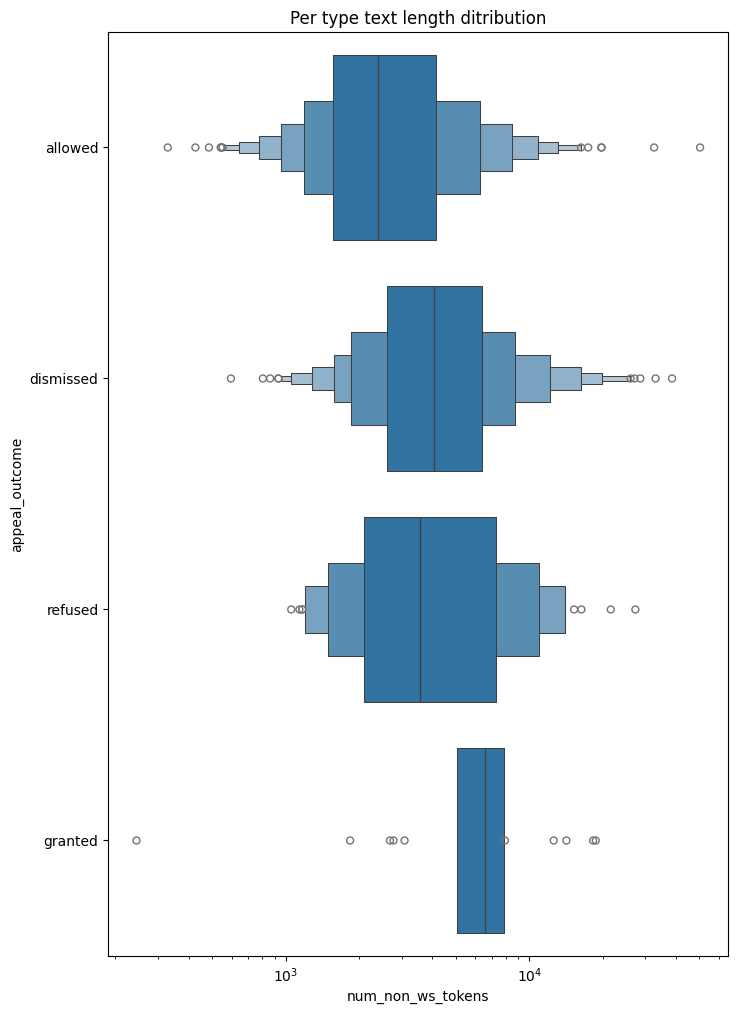

In [30]:
# | eval: false
# sns.displot(data=stats, x="num_non_ws_tokens", col="type", col_wrap=3, log_scale=(True, False), facet_kws=dict(sharey=False, sharex=False), kind="hist", bins=25)

_, ax = plt.subplots(figsize=(8, 12))
ax.set(title="Per type text length ditribution")
sns.boxenplot(data=stats, y="appeal_outcome", x="num_non_ws_tokens", order=appeal_outcome_card_order, log_scale=True)

# Tokenize


In [32]:
# | eval: false
from transformers import AutoTokenizer

None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


In [33]:
# | eval: false
tokenizer = AutoTokenizer.from_pretrained("intfloat/multilingual-e5-large")
ds = ds.map(
    lambda examples: tokenizer(examples["content"], padding=False, truncation=False),
    batched=True,
    num_proc=44,
)

tokenizer_config.json:   0%|          | 0.00/418 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

Map (num_proc=44):   0%|          | 0/6154 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (1625 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (7729 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (4093 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (968 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2180 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for

In [34]:
# | eval: false
tokenized = []
for item in ds:
    tokenized.append({"num_tokens": len(item["input_ids"])})

In [48]:
num_tokens = [item['num_tokens'] for item in tokenized]
filtered_tokens = [token for token in num_tokens if token <= 40000]

<Axes: ylabel='Count'>

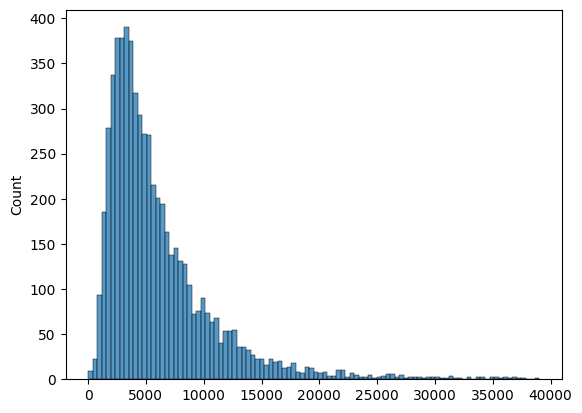

In [49]:
# | eval: false
sns.histplot(filtered_tokens, bins=100)

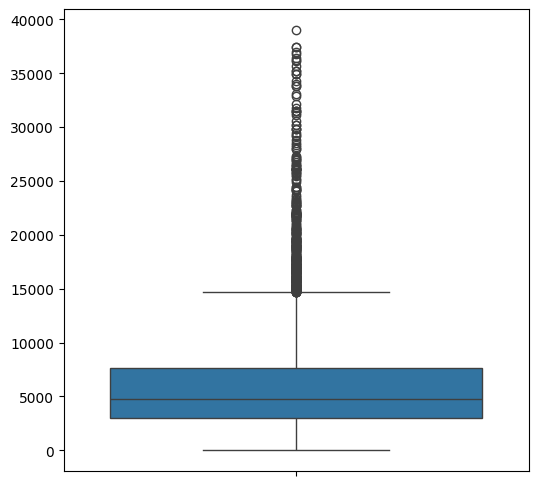

In [50]:
# Plot the box plot
plt.figure(figsize=(6, 6))
sns.boxplot(filtered_tokens)
plt.show()